In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import random
from typing import Callable
import pandas as pd

In [2]:
# Configuration
DATASET_PATH = "data"
ANNOTATIONS_FILE = os.path.join(DATASET_PATH, "annotations.json")
IMAGES_DIR = os.path.join(DATASET_PATH)
INPUT_SHAPE = (384, 384)
BATCH_SIZE = 4
EPOCHS = 20
LEARNING_RATE = 1e-4
NUM_WORKERS = 0

VOC_CLASSES = [
    "background",
    "turtle_head",
    "turtle_carapace",
    "turtle_flipper",
]

VOC_COLORMAP = [
    [128, 0, 128],    # background - purple
    [255, 255, 0],    # head - yellow
    [0, 128, 0],      # Carapace - green
    [0, 0, 255]       # flipper - blue
]

NUM_CLASSES = len(VOC_CLASSES)

# Create necessary directories
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('results', exist_ok=True)

class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)  # Global pooling reduces to 1x1
        self.conv = nn.Conv2d(in_channels, out_channels, 1, bias=False)  # 1x1 convolution
        self.relu = nn.ReLU()  # ReLU activation without normalization
    
    def forward(self, x):
        size = x.shape[-2:]
        x = self.pool(x)
        x = self.conv(x)
        x = self.relu(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)



class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256):
        super().__init__()
        modules = []
        
        # 1x1 convolution
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ))

        # Atrous convolutions
        for rate in atrous_rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        # Global pooling
        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)
        
        # Project
        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)

class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        # Load pretrained ResNet
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        
        # Encoder layers
        self.layer0 = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool
        )
        self.layer1 = backbone.layer1  # Low-level features
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        
        # Freeze backbone
        print("Freezing backbone parameters...")
        for layer in [self.layer0, self.layer1]:  
            for param in layer.parameters():
                param.requires_grad = False
        
        # ASPP
        self.aspp = ASPP(
            in_channels=2048,
            atrous_rates=[6, 12, 18]
        )
        
        # Low-level features processing
        self.low_level_conv = nn.Sequential(
            nn.Conv2d(256, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(304, 256, 3, padding=1, bias=False),  # 304 = 256(aspp) + 48(low_level)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(256, num_classes, 1)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        input_size = x.shape[-2:]
        
        # Encoder
        x = self.layer0(x)
        low_level_feat = self.layer1(x)
        x = self.layer2(low_level_feat)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # ASPP
        x = self.aspp(x)
        
        # Decoder
        x = F.interpolate(x, size=low_level_feat.shape[2:], mode='bilinear', align_corners=False)
        low_level_feat = self.low_level_conv(low_level_feat)
        
        x = torch.cat([x, low_level_feat], dim=1)
        x = self.decoder(x)
        
        # Final upsampling
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)
        
        return x

class TurtleSegDataset(Dataset):
    def __init__(self, image_paths, annotations, coco, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.annotations = annotations
        self.coco = coco
        self.transform = transform
        self.catIds = coco.getCatIds()
        
        print("Pre-computing masks...")
        self.masks = {}
        self.class_counts = {i: np.int64(0) for i in range(NUM_CLASSES)}

        # Pre-compute masks for each image
        for img_name in tqdm(self.image_paths, desc="Preprocessing"):
            img_id_list = [img['id'] for img in coco.dataset['images'] if img['file_name'] == img_name]
            if not img_id_list:
                print(f"Warning: Image '{img_name}' not found in COCO dataset.")
                continue  # Skip this image if not found

            img_id = img_id_list[0]  # Only proceed if image is found
            img_info = self.coco.loadImgs([img_id])[0]
            height, width = img_info['height'], img_info['width']
            
            mask = np.zeros((height, width), dtype=np.uint8)
            
            for ann in self.annotations.get(img_name, []):
                ann_id = ann['id']
                single_mask = self.coco.annToMask(self.coco.loadAnns([ann_id])[0])
                cat_id = ann['category_id']
                mask = np.where((single_mask == 1) & (mask == 0), cat_id, mask)

            self.masks[img_name] = mask
            for class_id in range(NUM_CLASSES):
                self.class_counts[class_id] += np.sum(mask == class_id)

        # Calculate class weights
        total = sum(self.class_counts.values())
        weights = {k: total / (v + 1e-8) for k, v in self.class_counts.items()}
        max_weight = max(weights.values())
        self.class_weights = {k: v / max_weight for k, v in weights.items()}
        print("Class weights:", self.class_weights)
        print("Class counts:", self.class_counts)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        
        # Load image
        img_info_list = [img for img in self.coco.dataset['images'] if img['file_name'] == img_name]
        if not img_info_list:
            raise ValueError(f"Image '{img_name}' not found in COCO dataset.")

        img_info = img_info_list[0]
        image = cv2.imread(os.path.join(IMAGES_DIR, img_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get mask
        mask = self.masks[img_name].copy()
        
        # Handle portrait images
        if image.shape[0] > image.shape[1]:
            image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
            mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
        
        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].long()  
        
        return image, mask



def get_training_augmentation():
    return A.Compose([
        A.RandomResizedCrop(
            height=INPUT_SHAPE[0],
            width=INPUT_SHAPE[1],
            scale=(0.7, 1.0),
            ratio=(0.8, 1.2)
        ),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=45,
            p=0.8
        ),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.8),
            A.RandomGamma(p=0.8),
        ], p=0.5),
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120 * 0.05, p=1.0),
            A.GridDistortion(p=1.0),
            A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1.0),
        ], p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

def get_validation_augmentation():
    return A.Compose([
        A.Resize(
            height=INPUT_SHAPE[0],
            width=INPUT_SHAPE[1]
        ),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()
        
        intersection = (inputs * targets_one_hot).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()
    
def create_model(num_classes):
    model = DeepLabV3Plus(num_classes=num_classes)
    
  
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f'Total parameters: {total_params:,}')
    print(f'Trainable parameters: {trainable_params:,}')
    print(f'Frozen parameters: {total_params - trainable_params:,}')
    
    return model

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()
        self.dice = DiceLoss()
        self.focal = FocalLoss(gamma=gamma)
    
    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        focal_loss = self.focal(inputs, targets)
        return self.alpha * (ce_loss + focal_loss) + (1 - self.alpha) * dice_loss

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


def visualize_sample_predictions(model, test_loader, num_samples=6, device='cpu'):
    model.eval()
    
    # Set up subplots
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    fig.suptitle('Segmentation Results on Test Set', fontsize=16)
    
    # Color mapping for classes
    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # Carapace - green
        3: [0, 0, 255]     # flipper - blue
    }
    
    metrics_per_image = []
    
    with torch.no_grad():
        for idx, (images, masks) in enumerate(test_loader):
            if idx >= num_samples:
                break
            
            # Move images to the device
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)[0].cpu().numpy()
            
            # Retrieve the original mask and calculate IoU for each class
            mask = masks[0].numpy()
            ious = []
            for class_id in range(NUM_CLASSES):
                pred_mask = (preds == class_id)
                true_mask = (mask == class_id)
                intersection = np.logical_and(pred_mask, true_mask).sum()
                union = np.logical_or(pred_mask, true_mask).sum()
                iou = intersection / (union + 1e-7)
                ious.append(iou)
            
            # Prepare the original image for display and clip to [0, 1] for float
            image = images[0].cpu().numpy().transpose(1, 2, 0)
            image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
            image = np.clip(image, 0, 1)  # Clip to [0, 1] to ensure valid display range
            
            # Create colored true and predicted masks
            true_mask_colored = np.zeros((*mask.shape, 3), dtype=np.float32)
            pred_mask_colored = np.zeros((*preds.shape, 3), dtype=np.float32)
            for class_id, color in color_map.items():
                true_mask_colored[mask == class_id] = np.array(color) / 255.0  # Normalize color
                pred_mask_colored[preds == class_id] = np.array(color) / 255.0
            
            # Display images and metrics
            axes[idx, 0].imshow(image)
            axes[idx, 0].set_title('Original Image')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(true_mask_colored)
            axes[idx, 1].set_title('Ground Truth')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(pred_mask_colored)
            title = f'Prediction\n' + \
                    f'Background IoU: {ious[0]:.3f}\n' + \
                    f'Head IoU: {ious[1]:.3f}\n' + \
                    f'Carapace IoU: {ious[2]:.3f}\n' + \
                    f'Flipper IoU: {ious[3]:.3f}'
            axes[idx, 2].set_title(title)
            axes[idx, 2].axis('off')
            
            metrics_per_image.append({
                'Background IoU': ious[0],
                'Head IoU': ious[1],
                'Carapace IoU': ious[2],
                'Flipper IoU': ious[3],
                'Mean IoU': np.mean(ious)
            })
    
    plt.tight_layout()
    plt.show()
    
    # Display and return per-image metrics as a DataFrame
    metrics_df = pd.DataFrame(metrics_per_image)
    print("\nPer-image Segmentation Metrics:")
    print(metrics_df.round(3))
    
    mean_metrics = metrics_df.mean()
    print("\nAverage Metrics:")
    print(mean_metrics.round(3))
    
    return metrics_df

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=EPOCHS, device='cpu'):
    best_iou = 0.0
    patience = 7
    patience_counter = 0
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_mean_iou': [],
        'val_mean_iou': [],
        'class_ious': [],
        'lr': [],
        'best_epoch': 0
    }

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        train_class_intersections = np.zeros(NUM_CLASSES)
        train_class_unions = np.zeros(NUM_CLASSES)

        # Training phase
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, masks in pbar:
            # Move data to device
            images = images.to(device).float()
            masks = masks.to(device).long()
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Update metrics
            epoch_loss += loss.item()
            
            # Calculate training metrics
            with torch.no_grad():
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                masks_np = masks.cpu().numpy()
                
                for class_id in range(NUM_CLASSES):
                    pred_mask = (preds == class_id)
                    true_mask = (masks_np == class_id)
                    intersection = np.logical_and(pred_mask, true_mask).sum()
                    union = np.logical_or(pred_mask, true_mask).sum()
                    train_class_intersections[class_id] += intersection
                    train_class_unions[class_id] += union

            # Update progress bar
            current_lr = optimizer.param_groups[0]['lr']
            train_class_ious = train_class_intersections / (train_class_unions + 1e-7)
            train_mean_iou = np.mean(train_class_ious)
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'mean_iou': f'{train_mean_iou:.4f}',
                'lr': f'{current_lr:.6f}'
            })

        # Calculate epoch-level training metrics
        train_loss = epoch_loss / len(train_loader)
        train_class_ious = train_class_intersections / (train_class_unions + 1e-7)
        train_mean_iou = np.mean(train_class_ious)
        
        # Validation phase
        print("\nRunning validation...")
        val_metrics = evaluate_model(model, val_loader, criterion, device)
        val_loss = val_metrics["loss"]
        val_class_iou = val_metrics["class_iou"]
        val_mean_iou = val_metrics["mean_iou"]

        # Adjust learning rate
        if scheduler is not None:
            scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mean_iou'].append(train_mean_iou)
        history['val_mean_iou'].append(val_mean_iou)
        history['class_ious'].append(val_class_iou)
        history['lr'].append(current_lr)

        # Print epoch results
        print(f'\nEpoch {epoch + 1} Results:')
        print(f'Train Loss: {train_loss:.4f}, Train Mean IoU: {train_mean_iou:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Mean IoU: {val_mean_iou:.4f}')
        print('\nPer-class IoU:')
        for i in range(NUM_CLASSES):
            print(f'{VOC_CLASSES[i]}: Train: {train_class_ious[i]:.4f}, Val: {val_class_iou[i]:.4f}')

        # Save best model
        if val_mean_iou > best_iou:
            best_iou = val_mean_iou
            history['best_epoch'] = epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'best_iou': best_iou,
                'history': history,  # Save training history with the checkpoint
            }, 'checkpoints/best_model.pth')
            patience_counter = 0
            print(f'\nNew best model saved! Best Val Mean IoU: {best_iou:.4f}')
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after {epoch + 1} epochs')
            break

        # Save visualization every 5 epochs
        if (epoch + 1) % 5 == 0:
            print("\nSaving validation visualization...")
            visualize_predictions(model, val_loader, save_path=f'results/epoch_{epoch+1}.png', device=device)

    print("\nTraining completed!")
    return model, history



def calculate_iou(preds, targets, num_classes=NUM_CLASSES):
    ious = []
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()
        
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum() - intersection
        if union == 0:
            iou = torch.tensor(1.0)  # If no ground truth or prediction for this class, IoU is 1
        else:
            iou = intersection / union
        ious.append(iou)
    
    return torch.stack(ious)  # Returns a tensor of IoUs per class

def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    class_intersections = np.zeros(NUM_CLASSES)
    class_unions = np.zeros(NUM_CLASSES)

    with torch.no_grad():
        for images, masks in loader:
            # Move images and masks to the device
            images = images.to(device).float()
            masks = masks.to(device).long()
            
            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.cpu().numpy()
            
            for class_id in range(NUM_CLASSES):
                pred_mask = (preds == class_id)
                true_mask = (masks == class_id)
                intersection = np.logical_and(pred_mask, true_mask).sum()
                union = np.logical_or(pred_mask, true_mask).sum()
                class_intersections[class_id] += intersection
                class_unions[class_id] += union

    class_ious = class_intersections / (class_unions + 1e-7)
    mean_iou = np.mean(class_ious)
    avg_loss = total_loss / len(loader)

    return {
        "loss": avg_loss,
        "class_iou": class_ious,
        "mean_iou": mean_iou
    }

def plot_training_history(history):
    # Create figure with three subplots
    fig = plt.figure(figsize=(20, 5))
    
    # 1. Training Metrics (Loss)
    plt.subplot(131)
    plt.plot(history['train_loss'], '-', color='blue', label='Train Loss')
    plt.plot(history['val_loss'], '--', color='red', label='Validation Loss')
    plt.title('Training Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # 2. Validation Mean IoU
    plt.subplot(132)
    # Calculate validation mean IoU from class IoUs if not directly available
    if 'val_mean_iou' not in history or not history['val_mean_iou']:
        val_mean_ious = [np.mean(epoch_ious) for epoch_ious in history['class_ious']]
    else:
        val_mean_ious = history['val_mean_iou']
    
    plt.plot(val_mean_ious, '--', color='orange', label='Validation Mean IoU')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Mean IoU')
    plt.legend()
    plt.grid(True)
    
    # 3. Class IoU Metrics
    plt.subplot(133)
    colors = ['blue', 'orange', 'green', 'red']  
    class_ious = np.array(history['class_ious'])
    
    for i, (class_name, color) in enumerate(zip(VOC_CLASSES, colors)):
        plt.plot(class_ious[:, i], '-', color=color, label=class_name)
    
    plt.title('Class IoU Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('results/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def visualize_predictions(model, loader, num_samples=3, device='cpu', save_path=None):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    
    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # Carapace - green
        3: [0, 0, 255]     # flipper - blue
    }
    
    with torch.no_grad():
        for idx, (images, masks) in enumerate(loader):
            if idx >= num_samples:
                break
            
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)[0].cpu().numpy()
            
            # Prepare the original image for display
            image = images[0].cpu().numpy().transpose(1, 2, 0)
            image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
            image = np.clip(image, 0, 1)
            
            # Generate colored masks
            true_mask = masks[0].cpu().numpy()
            true_mask_colored = np.zeros((*true_mask.shape, 3), dtype=np.float32)
            pred_mask_colored = np.zeros((*preds.shape, 3), dtype=np.float32)
            
            for class_id, color in color_map.items():
                true_mask_colored[true_mask == class_id] = np.array(color) / 255.0
                pred_mask_colored[preds == class_id] = np.array(color) / 255.0
            
            # Display images and masks
            axes[idx, 0].imshow(image)
            axes[idx, 0].set_title('Original Image')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(true_mask_colored)
            axes[idx, 1].set_title('Ground Truth')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(pred_mask_colored)
            axes[idx, 2].set_title('Prediction')
            axes[idx, 2].axis('off')
    
    plt.tight_layout()
    
    # Save the figure if save_path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
        plt.close()
        print(f"Visualization saved to {save_path}")
    else:
        plt.show()




def plot_metrics(history, voc_classes):
    epochs = range(len(history['train_loss']))
    
    # Figure setup
    plt.figure(figsize=(20, 5))

    # 1. Training and Validation Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', color='blue')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Metrics')
    plt.legend()

    # 2. Validation Mean IoU
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_mean_iou'], label='Validation Mean IoU', color='orange', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Mean IoU')
    plt.title('Validation Metrics')
    plt.legend()

    # 3. Class-wise IoU
    plt.subplot(1, 3, 3)
    colors = ['blue', 'orange', 'green', 'red']  # Adjust colors as needed
    for idx, class_name in enumerate(voc_classes):
        plt.plot(epochs, history['class_iou'][class_name], label=class_name, color=colors[idx])
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('Class IoU Metrics')
    plt.legend()

    # Adjust layout and save figure
    plt.tight_layout()
    plt.savefig('results/training_metrics.png')
    plt.show()

def visualize_sample_predictions(model, test_loader, num_samples=6, device='cpu'):
    model.eval()
    
    # Set up subplots
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    fig.suptitle('Segmentation Results on Test Set', fontsize=16)
    
    # Color mapping for classes
    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # Carapace - green
        3: [0, 0, 255]     # flipper - blue
    }
    
    metrics_per_image = []
    
    with torch.no_grad():
        for idx, (images, masks) in enumerate(test_loader):
            if idx >= num_samples:
                break
            
            # Move images to the device
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)[0].cpu().numpy()
            
            # Retrieve the original mask and calculate IoU for each class
            mask = masks[0].numpy()
            ious = []
            for class_id in range(NUM_CLASSES):
                pred_mask = (preds == class_id)
                true_mask = (mask == class_id)
                intersection = np.logical_and(pred_mask, true_mask).sum()
                union = np.logical_or(pred_mask, true_mask).sum()
                iou = intersection / (union + 1e-7)
                ious.append(iou)
            
            # Prepare the original image for display and clip to [0, 1] for float
            image = images[0].cpu().numpy().transpose(1, 2, 0)
            image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
            image = np.clip(image, 0, 1)  # Clip to [0, 1] to ensure valid display range
            
            # Create colored true and predicted masks
            true_mask_colored = np.zeros((*mask.shape, 3), dtype=np.float32)
            pred_mask_colored = np.zeros((*preds.shape, 3), dtype=np.float32)
            for class_id, color in color_map.items():
                true_mask_colored[mask == class_id] = np.array(color) / 255.0  # Normalize color
                pred_mask_colored[preds == class_id] = np.array(color) / 255.0
            
            # Display images and metrics
            axes[idx, 0].imshow(image)
            axes[idx, 0].set_title('Original Image')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(true_mask_colored)
            axes[idx, 1].set_title('Ground Truth')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(pred_mask_colored)
            title = f'Prediction\n' + \
                    f'Background IoU: {ious[0]:.3f}\n' + \
                    f'Head IoU: {ious[1]:.3f}\n' + \
                    f'Carapace IoU: {ious[2]:.3f}\n' + \
                    f'Flipper IoU: {ious[3]:.3f}'
            axes[idx, 2].set_title(title)
            axes[idx, 2].axis('off')
            
            metrics_per_image.append({
                'Background IoU': ious[0],
                'Head IoU': ious[1],
                'Carapace IoU': ious[2],
                'Flipper IoU': ious[3],
                'Mean IoU': np.mean(ious)
            })
    
    plt.tight_layout()
    plt.show()
    
    # Display and return per-image metrics as a DataFrame
    metrics_df = pd.DataFrame(metrics_per_image)
    print("\nPer-image Segmentation Metrics:")
    print(metrics_df.round(3))
    
    mean_metrics = metrics_df.mean()
    print("\nAverage Metrics:")
    print(mean_metrics.round(3))
    
    return metrics_df



def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    class_intersections = np.zeros(NUM_CLASSES)
    class_unions = np.zeros(NUM_CLASSES)

    with torch.no_grad():
        for images, masks in loader:
            # Move images and masks to the device
            images = images.to(device).float()
            masks = masks.to(device).long()
            
            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.cpu().numpy()
            
            for class_id in range(NUM_CLASSES):
                pred_mask = (preds == class_id)
                true_mask = (masks == class_id)
                intersection = np.logical_and(pred_mask, true_mask).sum()
                union = np.logical_or(pred_mask, true_mask).sum()
                class_intersections[class_id] += intersection
                class_unions[class_id] += union

    class_ious = class_intersections / (class_unions + 1e-7)
    mean_iou = np.mean(class_ious)
    avg_loss = total_loss / len(loader)

    return {
        "loss": avg_loss,
        "class_iou": class_ious,
        "mean_iou": mean_iou
    }


def visualize_best_predictions(model, test_loader, device='cpu'):
    model.eval()
    
    # Color mapping for classes
    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # Carapace - green
        3: [0, 0, 255]     # flipper - blue
    }
    
    images_list = []
    masks_list = []
    preds_list = []
    metrics_list = []
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.numpy()
            images_cpu = images.cpu().numpy()
            
            batch_size = images.shape[0]
            
            for i in range(batch_size):
                image = images_cpu[i]
                pred = preds[i]
                mask = masks[i]
                
                # Compute IoU per class
                ious = []
                for class_id in range(NUM_CLASSES):
                    pred_mask = (pred == class_id)
                    true_mask = (mask == class_id)
                    intersection = np.logical_and(pred_mask, true_mask).sum()
                    union = np.logical_or(pred_mask, true_mask).sum()
                    iou = intersection / (union + 1e-7)
                    ious.append(iou)
                mean_iou = np.mean(ious)
                
                # Append data
                images_list.append(image)
                masks_list.append(mask)
                preds_list.append(pred)
                metrics_list.append({
                    'Background IoU': ious[0],
                    'Head IoU': ious[1],
                    'Carapace IoU': ious[2],
                    'Flipper IoU': ious[3],
                    'Mean IoU': mean_iou
                })
        
    # Create DataFrame and sort by Mean IoU
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df_sorted = metrics_df.sort_values(by='Mean IoU')
    
    # Get indices of best images
    best_indices = metrics_df_sorted.index[-3:].tolist()
    
    selected_indices = best_indices
    
    # Set up subplots using GridSpec
    num_samples = 3
    fig = plt.figure(figsize=(15, 5 * num_samples))
    fig.suptitle('Segmentation Results on Test Set', fontsize=16, y=0.99)
    
    gs = plt.GridSpec(num_samples, 3, figure=fig)
    
    # Add labels for best results
    fig.text(0.5, 0.94, 'Best Segmentation Results', ha='center', fontsize=18)
    
    for idx, index in enumerate(selected_indices):
        image = images_list[index]
        mask = masks_list[index]
        pred = preds_list[index]
        ious = metrics_df.iloc[index][['Background IoU', 'Head IoU', 'Carapace IoU', 'Flipper IoU']].values
        
        row = idx
        col = 0
        ax0 = fig.add_subplot(gs[row, col])
        ax1 = fig.add_subplot(gs[row, col + 1])
        ax2 = fig.add_subplot(gs[row, col + 2])
        
        # Prepare the original image for display and clip to [0, 1] for float
        image_disp = image.transpose(1, 2, 0)
        image_disp = (image_disp - image_disp.min()) / (image_disp.max() - image_disp.min())  # Normalize to [0, 1]
        image_disp = np.clip(image_disp, 0, 1)  # Clip to [0, 1] to ensure valid display range
        
        # Create colored true and predicted masks
        true_mask_colored = np.zeros((*mask.shape, 3), dtype=np.float32)
        pred_mask_colored = np.zeros((*pred.shape, 3), dtype=np.float32)
        for class_id, color in color_map.items():
            true_mask_colored[mask == class_id] = np.array(color) / 255.0  # Normalize color
            pred_mask_colored[pred == class_id] = np.array(color) / 255.0
        
        # Display images and metrics
        ax0.imshow(image_disp)
        ax0.set_title('Original Image')
        ax0.axis('off')
        
        ax1.imshow(true_mask_colored)
        ax1.set_title('Ground Truth')
        ax1.axis('off')
        
        ax2.imshow(pred_mask_colored)
        title = f'Prediction\n' + \
                f'Background IoU: {ious[0]:.3f}\n' + \
                f'Head IoU: {ious[1]:.3f}\n' + \
                f'Carapace IoU: {ious[2]:.3f}\n' + \
                f'Flipper IoU: {ious[3]:.3f}\n' + \
                f'Mean IoU: {np.mean(ious):.3f}'
        ax2.set_title(title)
        ax2.axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to make room for the labels
    plt.show()
    
    return metrics_df

def visualize_worst_predictions(model, test_loader, device='cpu'):
    model.eval()
    
    # Color mapping for classes
    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # Carapace - green
        3: [0, 0, 255]     # flipper - blue
    }
    
    images_list = []
    masks_list = []
    preds_list = []
    metrics_list = []
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.numpy()
            images_cpu = images.cpu().numpy()
            
            batch_size = images.shape[0]
            
            for i in range(batch_size):
                image = images_cpu[i]
                pred = preds[i]
                mask = masks[i]
                
                # Compute IoU per class
                ious = []
                for class_id in range(NUM_CLASSES):
                    pred_mask = (pred == class_id)
                    true_mask = (mask == class_id)
                    intersection = np.logical_and(pred_mask, true_mask).sum()
                    union = np.logical_or(pred_mask, true_mask).sum()
                    iou = intersection / (union + 1e-7)
                    ious.append(iou)
                mean_iou = np.mean(ious)
                
                # Append data
                images_list.append(image)
                masks_list.append(mask)
                preds_list.append(pred)
                metrics_list.append({
                    'Background IoU': ious[0],
                    'Head IoU': ious[1],
                    'Carapace IoU': ious[2],
                    'Flipper IoU': ious[3],
                    'Mean IoU': mean_iou
                })
        
    # Create DataFrame and sort by Mean IoU
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df_sorted = metrics_df.sort_values(by='Mean IoU')
    
    # Get indices of worst images
    worst_indices = metrics_df_sorted.index[:3].tolist()
    
    selected_indices = worst_indices
    
    # Set up subplots using GridSpec
    num_samples = 3
    fig = plt.figure(figsize=(15, 5 * num_samples))
    fig.suptitle('Segmentation Results on Test Set', fontsize=16, y=0.99)
    
    gs = plt.GridSpec(num_samples, 3, figure=fig)
    
    # Add labels for worst results
    fig.text(0.5, 0.94, 'Worst Segmentation Results', ha='center', fontsize=18)
    
    for idx, index in enumerate(selected_indices):
        image = images_list[index]
        mask = masks_list[index]
        pred = preds_list[index]
        ious = metrics_df.iloc[index][['Background IoU', 'Head IoU', 'Carapace IoU', 'Flipper IoU']].values
        
        row = idx
        col = 0
        ax0 = fig.add_subplot(gs[row, col])
        ax1 = fig.add_subplot(gs[row, col + 1])
        ax2 = fig.add_subplot(gs[row, col + 2])
        
        # Prepare the original image for display and clip to [0, 1] for float
        image_disp = image.transpose(1, 2, 0)
        image_disp = (image_disp - image_disp.min()) / (image_disp.max() - image_disp.min())  # Normalize to [0, 1]
        image_disp = np.clip(image_disp, 0, 1)  # Clip to [0, 1] to ensure valid display range
        
        # Create colored true and predicted masks
        true_mask_colored = np.zeros((*mask.shape, 3), dtype=np.float32)
        pred_mask_colored = np.zeros((*pred.shape, 3), dtype=np.float32)
        for class_id, color in color_map.items():
            true_mask_colored[mask == class_id] = np.array(color) / 255.0  # Normalize color
            pred_mask_colored[pred == class_id] = np.array(color) / 255.0
        
        # Display images and metrics
        ax0.imshow(image_disp)
        ax0.set_title('Original Image')
        ax0.axis('off')
        
        ax1.imshow(true_mask_colored)
        ax1.set_title('Ground Truth')
        ax1.axis('off')
        
        ax2.imshow(pred_mask_colored)
        title = f'Prediction\n' + \
                f'Background IoU: {ious[0]:.3f}\n' + \
                f'Head IoU: {ious[1]:.3f}\n' + \
                f'Carapace IoU: {ious[2]:.3f}\n' + \
                f'Flipper IoU: {ious[3]:.3f}\n' + \
                f'Mean IoU: {np.mean(ious):.3f}'
        ax2.set_title(title)
        ax2.axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to make room for the labels
    plt.show()
    
    return metrics_df



In [3]:

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Select device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load COCO dataset
print("Loading COCO dataset...")
coco = COCO(ANNOTATIONS_FILE)

# Map image IDs to file names
image_id_to_filename = {img['id']: img['file_name'] for img in coco.dataset['images']}

# Create annotations_dict mapping image file names to their annotations
annotations_dict = {}
for annotation in coco.loadAnns(coco.getAnnIds()):
    image_id = annotation['image_id']
    if image_id in image_id_to_filename:
        image_file_name = image_id_to_filename[image_id]
        annotations_dict.setdefault(image_file_name, []).append(annotation)
    else:
        print(f"Warning: image_id {image_id} in annotations does not have a corresponding image.")

# Display basic information about annotations
if annotations_dict:
    first_image = list(annotations_dict.keys())[0]
    print(f"Number of unique images with annotations: {len(annotations_dict)}")
    # print(f"Example annotations for {first_image}: {annotations_dict[first_image]}")
else:
    print("No annotations found in dataset.")

# Find images that have no annotations
images_without_annotations = [
    file_name for file_name in image_id_to_filename.values()
    if file_name not in annotations_dict
]
print(f"\nNumber of images without annotations: {len(images_without_annotations)}")

# Load metadata CSV for dataset splits
metadata_file = 'data/metadata_splits.csv'
metadata_df = pd.read_csv(metadata_file)

# Column specifying split type
split_column = 'split_open'

# Image IDs with incorrect annotations to exclude
bad_image_ids = [7772, 8436, 1958, 4566, 6730, 6732, 6733, 6735, 7187, 3975, 3793, 1880, 3739, 5950, 6728, 6729, 6731, 6734, 6736, 6936]

# Create dataset splits based on CSV and exclude bad annotations
train_df = metadata_df[(metadata_df[split_column] == 'train') & (~metadata_df['id'].isin(bad_image_ids))]
valid_df = metadata_df[(metadata_df[split_column] == 'valid') & (~metadata_df['id'].isin(bad_image_ids))]
test_df = metadata_df[(metadata_df[split_column] == 'test') & (~metadata_df['id'].isin(bad_image_ids))]

# Ensure only images with annotations are included in each split
train_image_paths = [img for img in train_df['file_name'] if img in annotations_dict]
valid_image_paths = [img for img in valid_df['file_name'] if img in annotations_dict]
test_image_paths = [img for img in test_df['file_name'] if img in annotations_dict]

# Filter annotation dictionaries for each split
train_annotations = {k: annotations_dict[k] for k in train_image_paths}
valid_annotations = {k: annotations_dict[k] for k in valid_image_paths}
test_annotations = {k: annotations_dict[k] for k in test_image_paths}

# Print dataset split summaries
print(f"Training set contains {len(train_annotations)} images.")
print(f"Validation set contains {len(valid_annotations)} images.")
print(f"Test set contains {len(test_annotations)} images.")

# Create datasets and data loaders
print("\nCreating datasets...")
train_dataset = TurtleSegDataset(train_image_paths, train_annotations, coco, transform=get_training_augmentation())
val_dataset = TurtleSegDataset(valid_image_paths, valid_annotations, coco, transform=get_validation_augmentation())
test_dataset = TurtleSegDataset(test_image_paths, test_annotations, coco, transform=get_validation_augmentation())

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

Using device: cuda
Loading COCO dataset...
loading annotations into memory...
Done (t=3.33s)
creating index...
index created!
Number of unique images with annotations: 8726

Number of images without annotations: 3
Training set contains 5293 images.
Validation set contains 1117 images.
Test set contains 2299 images.

Creating datasets...
Pre-computing masks...


Preprocessing: 100%|██████████| 5293/5293 [03:21<00:00, 26.23it/s]


Class weights: {0: 0.016291943313190723, 1: 0.11788785213471105, 2: 0.8058324000050349, 3: 1.0}
Class counts: {0: 12118789834, 1: 1674800528, 2: 245012036, 3: 197438637}
Pre-computing masks...


Preprocessing: 100%|██████████| 1117/1117 [00:46<00:00, 23.82it/s]


Class weights: {0: 0.013626295517150775, 1: 0.12438158966942733, 2: 0.6775461311557179, 3: 1.0}
Class counts: {0: 2601845524, 1: 285038293, 2: 52326350, 3: 35453516}
Pre-computing masks...


Preprocessing: 100%|██████████| 2299/2299 [01:36<00:00, 23.93it/s]

Class weights: {0: 0.010572729531563659, 1: 0.08895650326549066, 2: 0.6393658891643924, 3: 1.0}
Class counts: {0: 5350832236, 1: 635961396, 2: 88482828, 3: 56572902}


In [6]:
# Create and move the model to device
print("\nCreating model...")
model = create_model(num_classes=NUM_CLASSES).to(device)

# Setup loss and optimizer, move criterion to device if necessary
print("\nSetting up loss function and optimizer...")
criterion = CombinedLoss(alpha=0.5).to(device)
optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=1e-4
)

# Setup scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Train the model
print("\nStarting training...")
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=EPOCHS
)



Creating model...
Freezing backbone parameters...
Total parameters: 40,347,300
Trainable parameters: 40,121,956
Frozen parameters: 225,344

Setting up loss function and optimizer...

Starting training...


Epoch 1/20: 100%|██████████| 1324/1324 [04:51<00:00,  4.55it/s, loss=0.6971, mean_iou=0.3608, lr=0.000100]



Running validation...

Epoch 1 Results:
Train Loss: 0.7068, Train Mean IoU: 0.3608
Val Loss: 0.5534, Val Mean IoU: 0.4187

Per-class IoU:
background: Train: 0.8768, Val: 0.9291
turtle_head: Train: 0.4526, Val: 0.4117
turtle_carapace: Train: 0.0383, Val: 0.1693
turtle_flipper: Train: 0.0754, Val: 0.1647

New best model saved! Best Val Mean IoU: 0.4187


Epoch 2/20: 100%|██████████| 1324/1324 [04:43<00:00,  4.66it/s, loss=0.3337, mean_iou=0.4594, lr=0.000100]



Running validation...

Epoch 2 Results:
Train Loss: 0.4885, Train Mean IoU: 0.4594
Val Loss: 0.4020, Val Mean IoU: 0.5109

Per-class IoU:
background: Train: 0.9232, Val: 0.9586
turtle_head: Train: 0.5650, Val: 0.5696
turtle_carapace: Train: 0.1334, Val: 0.2197
turtle_flipper: Train: 0.2159, Val: 0.2959

New best model saved! Best Val Mean IoU: 0.5109


Epoch 3/20: 100%|██████████| 1324/1324 [04:44<00:00,  4.65it/s, loss=0.5782, mean_iou=0.5035, lr=0.000100]



Running validation...

Epoch 3 Results:
Train Loss: 0.4436, Train Mean IoU: 0.5035
Val Loss: 0.3482, Val Mean IoU: 0.5593

Per-class IoU:
background: Train: 0.9351, Val: 0.9696
turtle_head: Train: 0.6014, Val: 0.6284
turtle_carapace: Train: 0.1959, Val: 0.2932
turtle_flipper: Train: 0.2817, Val: 0.3459

New best model saved! Best Val Mean IoU: 0.5593


Epoch 4/20: 100%|██████████| 1324/1324 [04:44<00:00,  4.65it/s, loss=0.3484, mean_iou=0.5292, lr=0.000100]



Running validation...

Epoch 4 Results:
Train Loss: 0.4121, Train Mean IoU: 0.5292
Val Loss: 0.3643, Val Mean IoU: 0.5450

Per-class IoU:
background: Train: 0.9440, Val: 0.9641
turtle_head: Train: 0.6255, Val: 0.5912
turtle_carapace: Train: 0.2338, Val: 0.2907
turtle_flipper: Train: 0.3134, Val: 0.3340


Epoch 5/20: 100%|██████████| 1324/1324 [04:42<00:00,  4.69it/s, loss=0.4030, mean_iou=0.5469, lr=0.000100]



Running validation...

Epoch 5 Results:
Train Loss: 0.3901, Train Mean IoU: 0.5469
Val Loss: 0.3265, Val Mean IoU: 0.5721

Per-class IoU:
background: Train: 0.9491, Val: 0.9725
turtle_head: Train: 0.6413, Val: 0.6614
turtle_carapace: Train: 0.2508, Val: 0.3065
turtle_flipper: Train: 0.3466, Val: 0.3479

New best model saved! Best Val Mean IoU: 0.5721

Saving validation visualization...
Visualization saved to results/epoch_5.png


Epoch 6/20: 100%|██████████| 1324/1324 [04:38<00:00,  4.75it/s, loss=0.3946, mean_iou=0.5639, lr=0.000100]



Running validation...

Epoch 6 Results:
Train Loss: 0.3774, Train Mean IoU: 0.5639
Val Loss: 0.3248, Val Mean IoU: 0.5812

Per-class IoU:
background: Train: 0.9525, Val: 0.9678
turtle_head: Train: 0.6544, Val: 0.6220
turtle_carapace: Train: 0.2698, Val: 0.3340
turtle_flipper: Train: 0.3787, Val: 0.4011

New best model saved! Best Val Mean IoU: 0.5812


Epoch 7/20: 100%|██████████| 1324/1324 [04:39<00:00,  4.74it/s, loss=0.3051, mean_iou=0.5731, lr=0.000100]



Running validation...

Epoch 7 Results:
Train Loss: 0.3646, Train Mean IoU: 0.5731
Val Loss: 0.3080, Val Mean IoU: 0.6038

Per-class IoU:
background: Train: 0.9557, Val: 0.9757
turtle_head: Train: 0.6643, Val: 0.6725
turtle_carapace: Train: 0.2815, Val: 0.3496
turtle_flipper: Train: 0.3908, Val: 0.4176

New best model saved! Best Val Mean IoU: 0.6038


Epoch 8/20: 100%|██████████| 1324/1324 [04:38<00:00,  4.75it/s, loss=0.0982, mean_iou=0.5814, lr=0.000100]



Running validation...

Epoch 8 Results:
Train Loss: 0.3533, Train Mean IoU: 0.5814
Val Loss: 0.3295, Val Mean IoU: 0.5763

Per-class IoU:
background: Train: 0.9589, Val: 0.9683
turtle_head: Train: 0.6762, Val: 0.6230
turtle_carapace: Train: 0.2958, Val: 0.2964
turtle_flipper: Train: 0.3947, Val: 0.4177


Epoch 9/20: 100%|██████████| 1324/1324 [04:38<00:00,  4.76it/s, loss=0.7450, mean_iou=0.5884, lr=0.000100]



Running validation...

Epoch 9 Results:
Train Loss: 0.3470, Train Mean IoU: 0.5884
Val Loss: 0.2960, Val Mean IoU: 0.6060

Per-class IoU:
background: Train: 0.9593, Val: 0.9779
turtle_head: Train: 0.6785, Val: 0.6654
turtle_carapace: Train: 0.3025, Val: 0.3633
turtle_flipper: Train: 0.4135, Val: 0.4173

New best model saved! Best Val Mean IoU: 0.6060


Epoch 10/20: 100%|██████████| 1324/1324 [04:39<00:00,  4.73it/s, loss=0.4817, mean_iou=0.5976, lr=0.000100]



Running validation...

Epoch 10 Results:
Train Loss: 0.3387, Train Mean IoU: 0.5976
Val Loss: 0.3162, Val Mean IoU: 0.5743

Per-class IoU:
background: Train: 0.9610, Val: 0.9695
turtle_head: Train: 0.6837, Val: 0.5881
turtle_carapace: Train: 0.3173, Val: 0.3743
turtle_flipper: Train: 0.4283, Val: 0.3654

Saving validation visualization...
Visualization saved to results/epoch_10.png


Epoch 11/20: 100%|██████████| 1324/1324 [04:37<00:00,  4.77it/s, loss=0.2830, mean_iou=0.5998, lr=0.000100]



Running validation...

Epoch 11 Results:
Train Loss: 0.3344, Train Mean IoU: 0.5998
Val Loss: 0.2960, Val Mean IoU: 0.6161

Per-class IoU:
background: Train: 0.9629, Val: 0.9754
turtle_head: Train: 0.6882, Val: 0.6627
turtle_carapace: Train: 0.3185, Val: 0.3691
turtle_flipper: Train: 0.4298, Val: 0.4574

New best model saved! Best Val Mean IoU: 0.6161


Epoch 12/20: 100%|██████████| 1324/1324 [04:44<00:00,  4.65it/s, loss=0.2084, mean_iou=0.6058, lr=0.000100]



Running validation...

Epoch 12 Results:
Train Loss: 0.3283, Train Mean IoU: 0.6058
Val Loss: 0.2840, Val Mean IoU: 0.6186

Per-class IoU:
background: Train: 0.9638, Val: 0.9802
turtle_head: Train: 0.6912, Val: 0.6898
turtle_carapace: Train: 0.3266, Val: 0.3545
turtle_flipper: Train: 0.4415, Val: 0.4498

New best model saved! Best Val Mean IoU: 0.6186


Epoch 13/20: 100%|██████████| 1324/1324 [04:53<00:00,  4.52it/s, loss=0.2525, mean_iou=0.6070, lr=0.000100]



Running validation...

Epoch 13 Results:
Train Loss: 0.3233, Train Mean IoU: 0.6070
Val Loss: 0.2786, Val Mean IoU: 0.6260

Per-class IoU:
background: Train: 0.9652, Val: 0.9829
turtle_head: Train: 0.6971, Val: 0.6968
turtle_carapace: Train: 0.3210, Val: 0.3766
turtle_flipper: Train: 0.4445, Val: 0.4477

New best model saved! Best Val Mean IoU: 0.6260


Epoch 14/20: 100%|██████████| 1324/1324 [05:04<00:00,  4.35it/s, loss=0.3658, mean_iou=0.6143, lr=0.000100]



Running validation...

Epoch 14 Results:
Train Loss: 0.3178, Train Mean IoU: 0.6143
Val Loss: 0.2742, Val Mean IoU: 0.6265

Per-class IoU:
background: Train: 0.9663, Val: 0.9832
turtle_head: Train: 0.7010, Val: 0.7078
turtle_carapace: Train: 0.3350, Val: 0.3685
turtle_flipper: Train: 0.4547, Val: 0.4466

New best model saved! Best Val Mean IoU: 0.6265


Epoch 15/20: 100%|██████████| 1324/1324 [05:11<00:00,  4.25it/s, loss=0.2640, mean_iou=0.6185, lr=0.000100]



Running validation...

Epoch 15 Results:
Train Loss: 0.3142, Train Mean IoU: 0.6185
Val Loss: 0.2713, Val Mean IoU: 0.6310

Per-class IoU:
background: Train: 0.9675, Val: 0.9840
turtle_head: Train: 0.7056, Val: 0.6965
turtle_carapace: Train: 0.3373, Val: 0.3937
turtle_flipper: Train: 0.4635, Val: 0.4497

New best model saved! Best Val Mean IoU: 0.6310

Saving validation visualization...
Visualization saved to results/epoch_15.png


Epoch 16/20: 100%|██████████| 1324/1324 [05:39<00:00,  3.90it/s, loss=0.2510, mean_iou=0.6203, lr=0.000100]



Running validation...

Epoch 16 Results:
Train Loss: 0.3105, Train Mean IoU: 0.6203
Val Loss: 0.2689, Val Mean IoU: 0.6373

Per-class IoU:
background: Train: 0.9683, Val: 0.9838
turtle_head: Train: 0.7107, Val: 0.7012
turtle_carapace: Train: 0.3386, Val: 0.3935
turtle_flipper: Train: 0.4637, Val: 0.4709

New best model saved! Best Val Mean IoU: 0.6373


Epoch 17/20: 100%|██████████| 1324/1324 [05:34<00:00,  3.95it/s, loss=1.3048, mean_iou=0.6252, lr=0.000100]



Running validation...

Epoch 17 Results:
Train Loss: 0.3092, Train Mean IoU: 0.6252
Val Loss: 0.2588, Val Mean IoU: 0.6495

Per-class IoU:
background: Train: 0.9688, Val: 0.9852
turtle_head: Train: 0.7138, Val: 0.7116
turtle_carapace: Train: 0.3443, Val: 0.4004
turtle_flipper: Train: 0.4740, Val: 0.5008

New best model saved! Best Val Mean IoU: 0.6495


Epoch 18/20: 100%|██████████| 1324/1324 [05:14<00:00,  4.21it/s, loss=0.2035, mean_iou=0.6230, lr=0.000100]



Running validation...

Epoch 18 Results:
Train Loss: 0.3054, Train Mean IoU: 0.6230
Val Loss: 0.2575, Val Mean IoU: 0.6492

Per-class IoU:
background: Train: 0.9699, Val: 0.9858
turtle_head: Train: 0.7088, Val: 0.7088
turtle_carapace: Train: 0.3491, Val: 0.4125
turtle_flipper: Train: 0.4643, Val: 0.4898


Epoch 19/20: 100%|██████████| 1324/1324 [05:45<00:00,  3.83it/s, loss=0.1471, mean_iou=0.6317, lr=0.000100]



Running validation...

Epoch 19 Results:
Train Loss: 0.3022, Train Mean IoU: 0.6317
Val Loss: 0.2559, Val Mean IoU: 0.6494

Per-class IoU:
background: Train: 0.9698, Val: 0.9866
turtle_head: Train: 0.7157, Val: 0.7263
turtle_carapace: Train: 0.3532, Val: 0.3964
turtle_flipper: Train: 0.4879, Val: 0.4882


Epoch 20/20: 100%|██████████| 1324/1324 [05:52<00:00,  3.75it/s, loss=0.2481, mean_iou=0.6322, lr=0.000100]



Running validation...

Epoch 20 Results:
Train Loss: 0.2958, Train Mean IoU: 0.6322
Val Loss: 0.2571, Val Mean IoU: 0.6496

Per-class IoU:
background: Train: 0.9719, Val: 0.9857
turtle_head: Train: 0.7214, Val: 0.7226
turtle_carapace: Train: 0.3509, Val: 0.4088
turtle_flipper: Train: 0.4844, Val: 0.4812

New best model saved! Best Val Mean IoU: 0.6496

Saving validation visualization...
Visualization saved to results/epoch_20.png

Training completed!



Plotting training history...


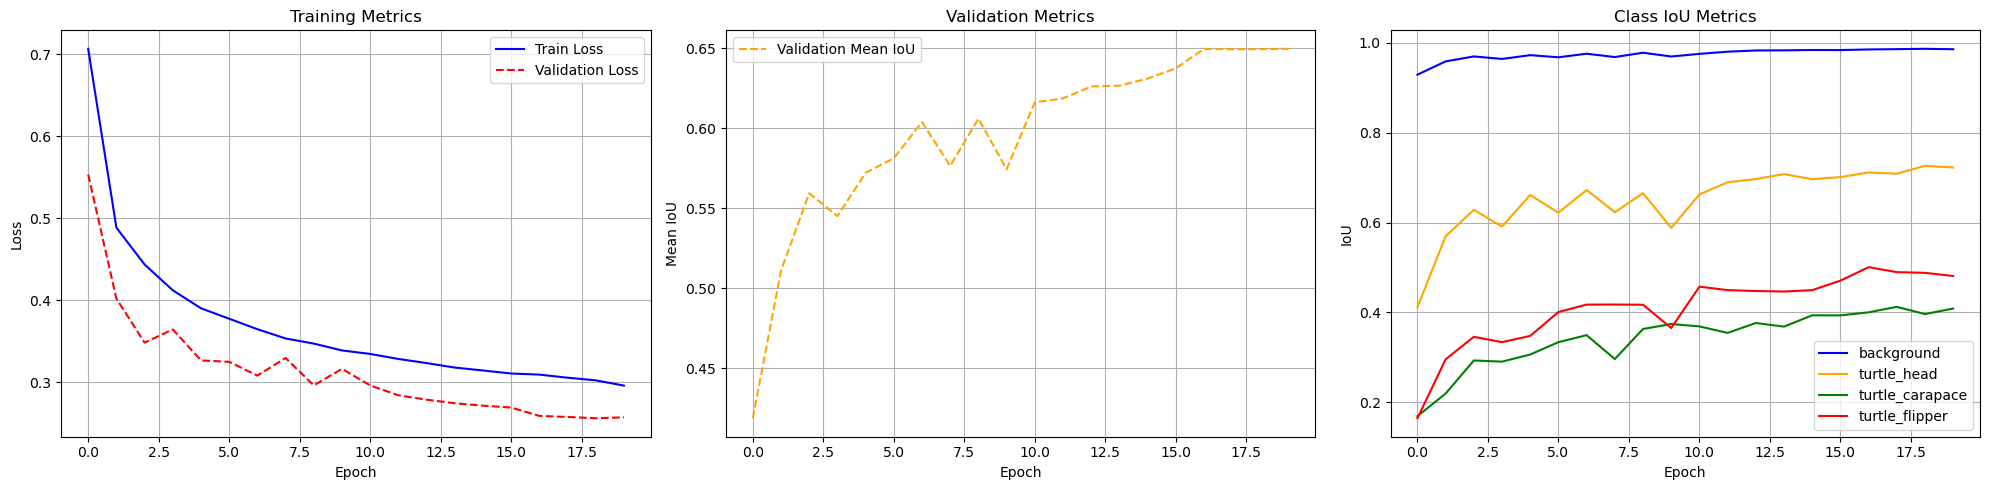


Loading best model for testing...

Evaluating on test set...

Test Results:
Test Mean IoU: 0.6129

Per-class IoU:
background: 0.9836
turtle_head: 0.7035
turtle_carapace: 0.3477
turtle_flipper: 0.4170

Generating final visualizations...
Visualization saved to results/final_predictions.png

Visualizing test set results...


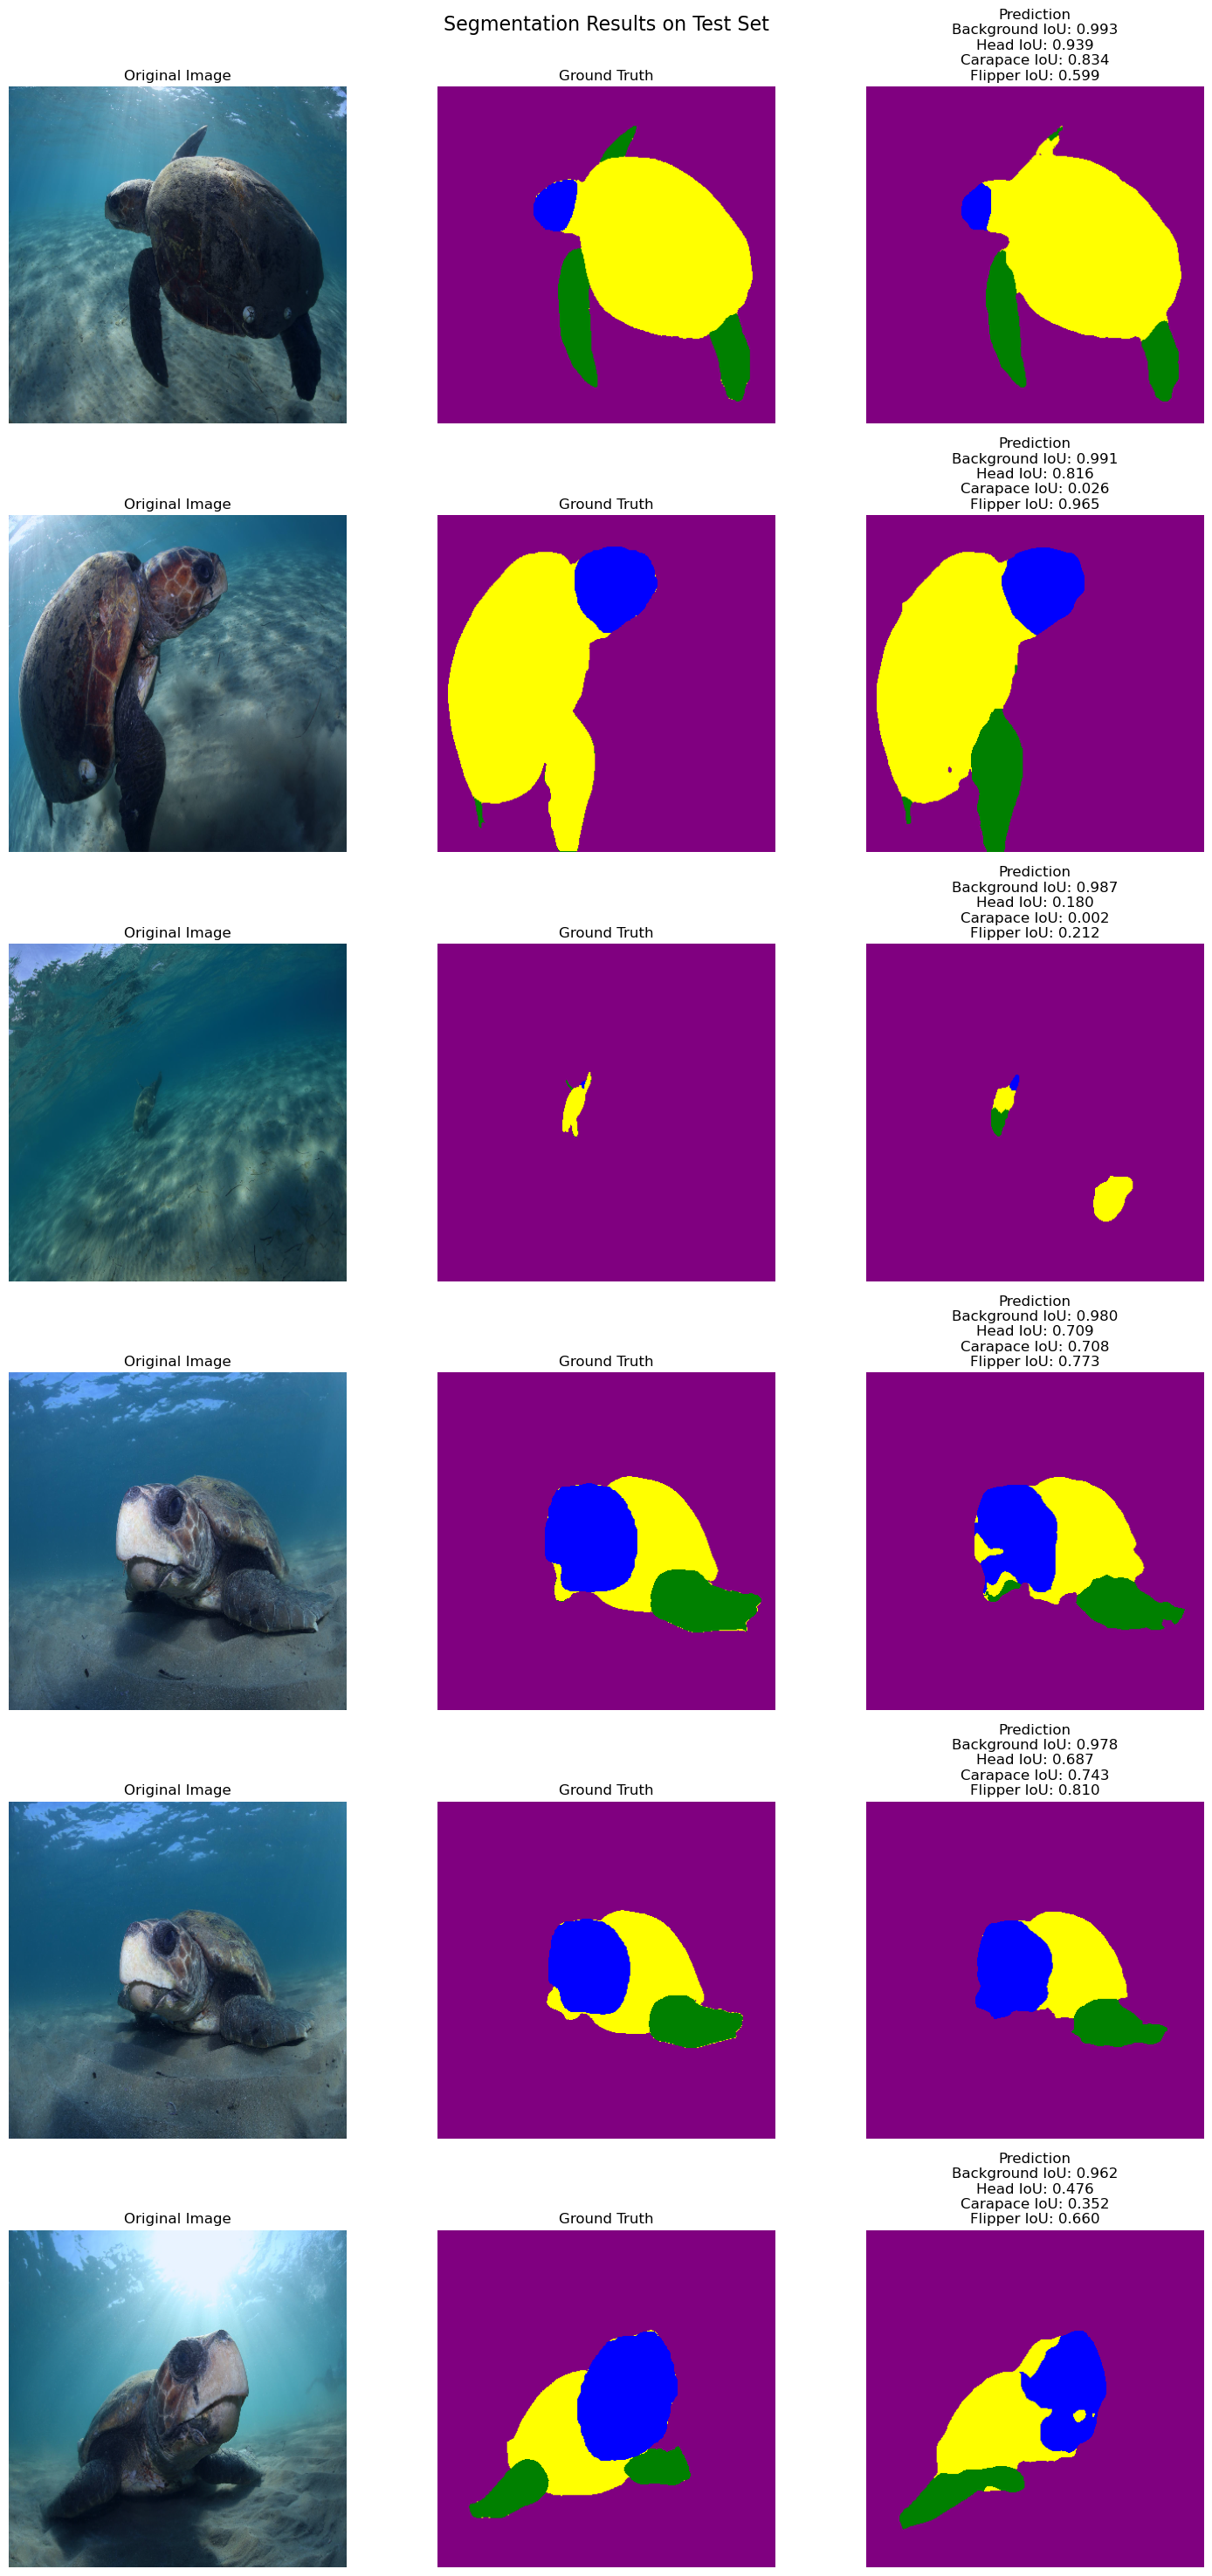


Per-image Segmentation Metrics:
   Background IoU  Head IoU  Carapace IoU  Flipper IoU  Mean IoU
0           0.993     0.939         0.834        0.599     0.841
1           0.991     0.816         0.026        0.965     0.700
2           0.987     0.180         0.002        0.212     0.345
3           0.980     0.709         0.708        0.773     0.793
4           0.978     0.687         0.743        0.810     0.804
5           0.962     0.476         0.352        0.660     0.612

Average Metrics:
Background IoU    0.982
Head IoU          0.634
Carapace IoU      0.444
Flipper IoU       0.670
Mean IoU          0.683
dtype: float64


In [7]:
# Plot training history
print("\nPlotting training history...")
plot_training_history(history)

# Load best model for testing
print("\nLoading best model for testing...")
checkpoint = torch.load(
    'checkpoints/best_model.pth',
    map_location=device,
    weights_only=False 
)
model.load_state_dict(checkpoint['model_state_dict'])

# Test evaluation
print("\nEvaluating on test set...")
test_metrics = evaluate_model(model, test_loader, criterion, device=device)  # Pass device

print("\nTest Results:")
print(f"Test Mean IoU: {test_metrics['mean_iou']:.4f}")
print("\nPer-class IoU:")
for i in range(NUM_CLASSES):
    print(f"{VOC_CLASSES[i]}: {test_metrics['class_iou'][i]:.4f}")

# Generate final visualizations
print("\nGenerating final visualizations...")
visualize_predictions(
    model,
    test_loader,
    num_samples=6,
    save_path='results/final_predictions.png',
    device=device  # Pass device
)

print("\nVisualizing test set results...")
metrics_df = visualize_sample_predictions(model, test_loader, device=device)  # Pass device





Visualizing the best and worst test set results...


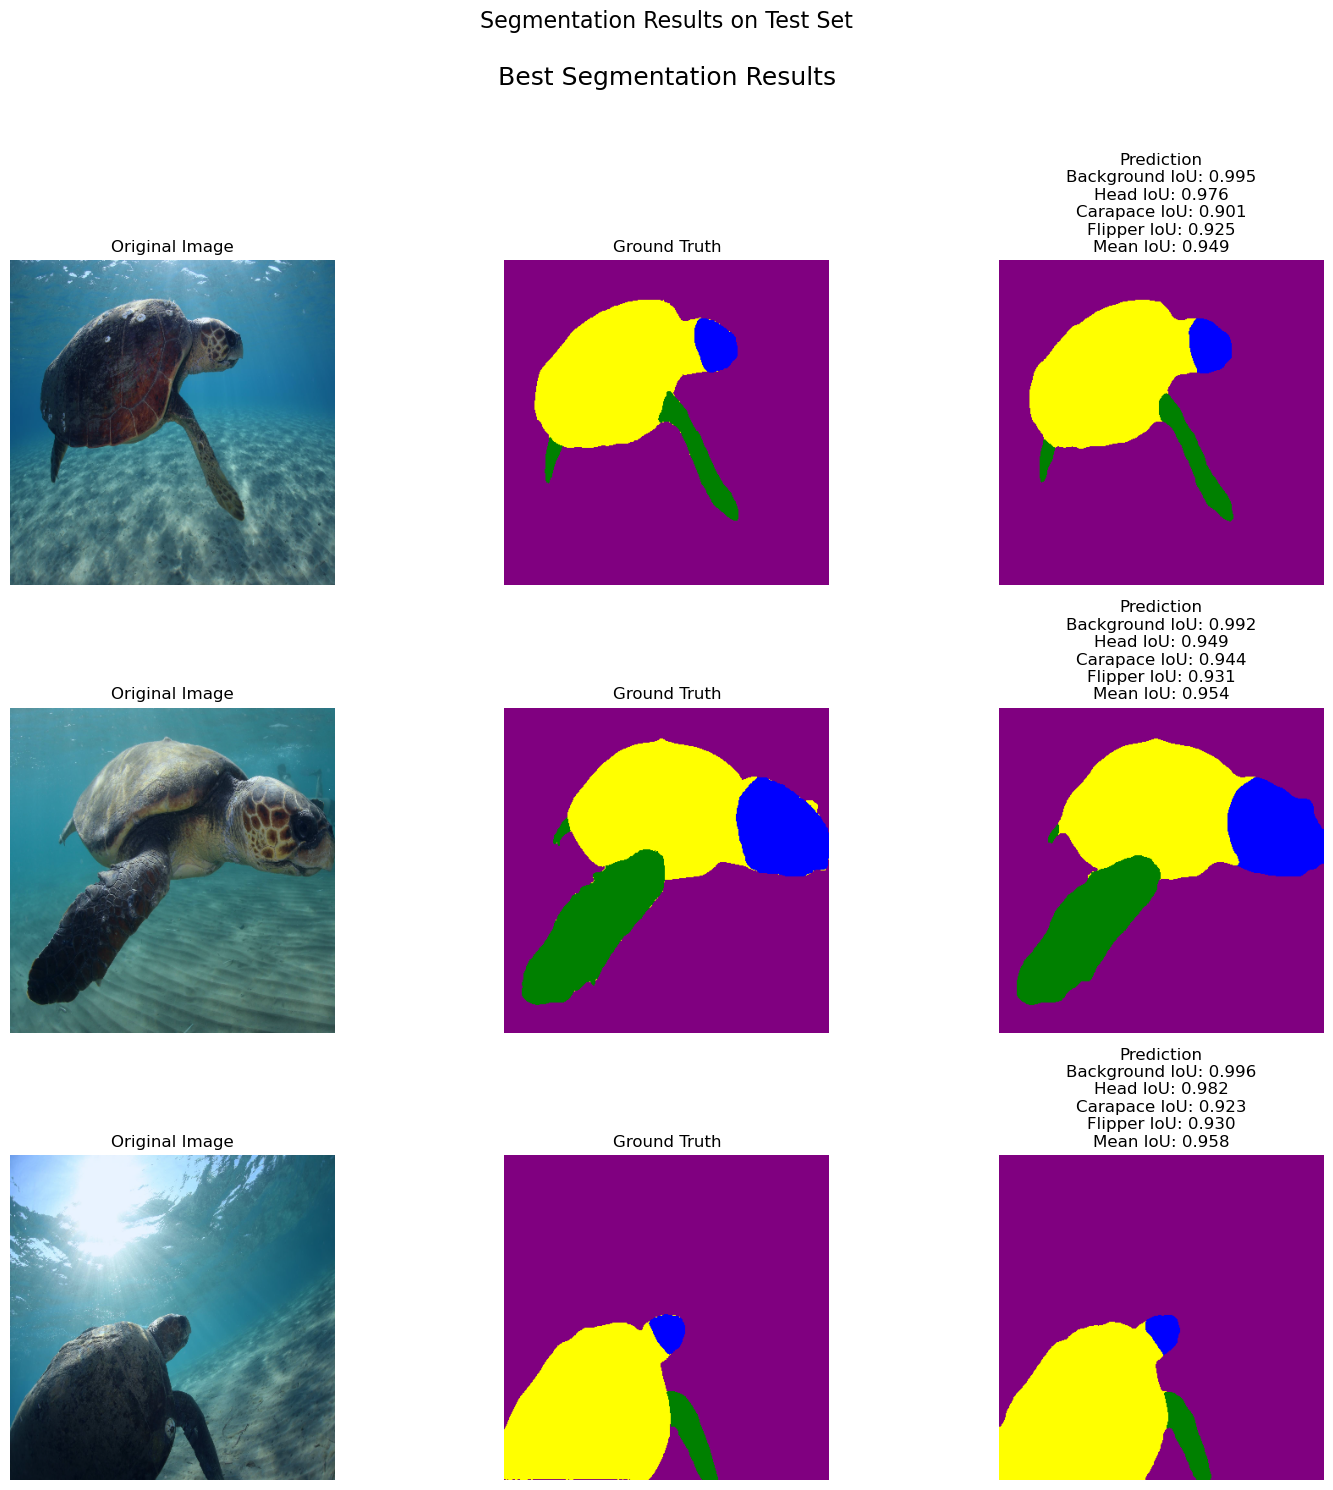

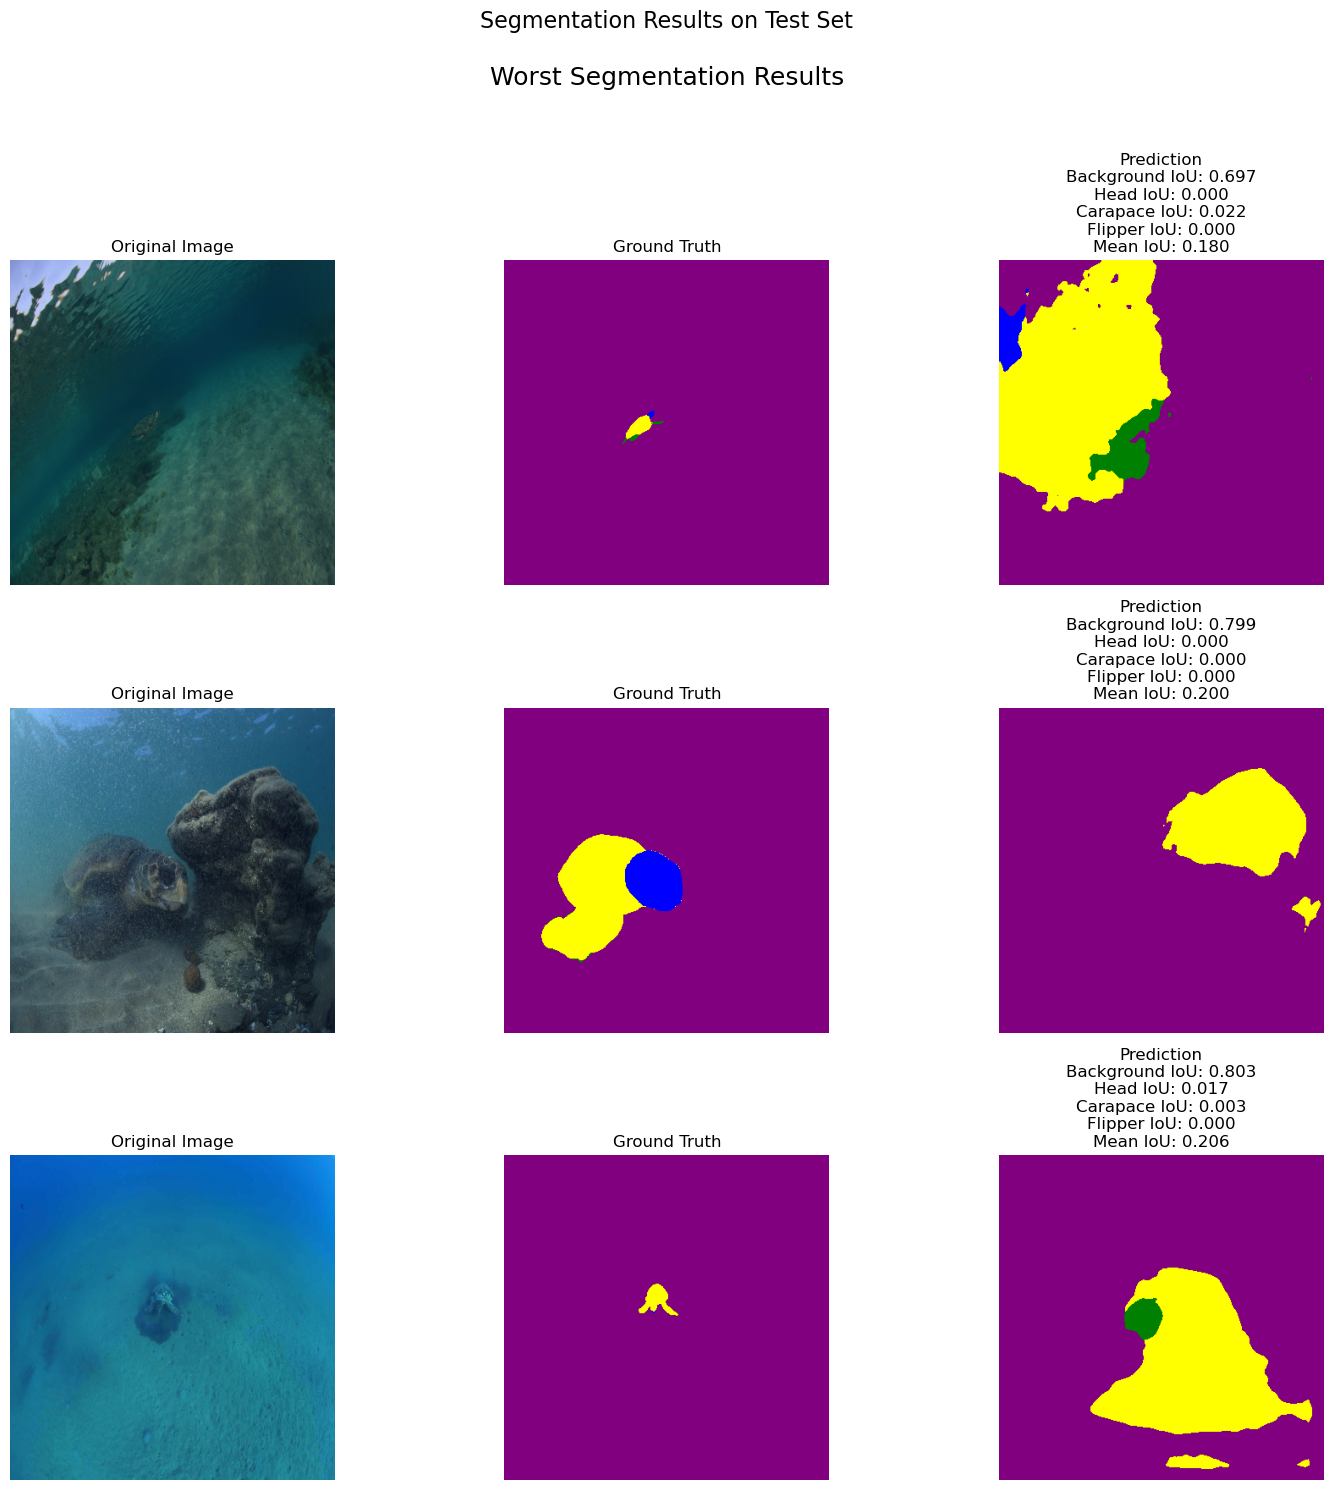


Training and evaluation completed successfully!


In [8]:
print("\nVisualizing the best and worst test set results...")
visualize_best_predictions(model, test_loader, device=device)
visualize_worst_predictions(model, test_loader, device=device)
print("\nTraining and evaluation completed successfully!")